## Main analysis - group differences?
Starter scripts in https://github.com/Gilles86/riskeye/blob/main/riskeye/eyetracking/

- Currently only did saccades, now also eyepos 

 fn = op.join(self.bids_folder, 'derivatives', 'pupil', f'sub-{self.subject_id}', 'func', f'sub-{self.subject_id}_run-{run}_gaze.tsv.gz')


--> explain stake-size effect with attention/fixation 

Sanity check?? 
- check match to behavior again (yes! - sub-01, key presses in eyetrack_messages & symbolic_events align)

--> last fixation inlfuences choice most (in positive or negative way - stake size ?!)

- saccades
- fixation times
- look at risky option more?
- DD only focus on one option (risky or save....)


- duration_option_dif_abs ~ stake-size effect ? (outliers?)

In [1]:
#from riskeye.utils.data import get_all_behavior, get_all_eyepos_info, get_all_subjects, Subject
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as op

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
plot_folder = op.join(bids_folder, 'plots_and_ims', 'eyetracking')


In [2]:
from utils import get_behavior, get_data
#df_behav = get_behavior()
df_behav = get_data()
df_behav = df_behav.xs(1,0,'session').xs('symbolic',0,'format')


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [4]:
# df = get_all_behavior(include_eyedata=True) does not work yet... 

source = 'eyepos' #'saccades'
summarized_fixations = pd.read_csv(op.join(bids_folder,f'derivatives/pupil/group_source-{source}_fixations_summary.tsv'), sep='\t')
summarized_fixations['trial_nr'] = summarized_fixations['trial'].astype(int)
summarized_fixations.set_index(['subject','trial_nr'], inplace=True)

df = df_behav.join(summarized_fixations)
df['n_saccades'] = df['n_saccades'].where((df['n_saccades'] < 9), np.nan) # remove outliers
# drop there rows!
df = df.dropna(subset=['n_saccades'])

In [5]:
df['n_right'] = df['n1']
df['n_left'] = df['n2']
df['p_right'] = df['prob1']
df['p_left'] = df['prob2']

df['n1'] = df['n_left'].where(df['first_saccade'] == 'left_option', df['n_right'])
df['p1'] = df['p_left'].where(df['first_saccade'] == 'left_option', df['p_right'])
df['n2'] = df['n_left'].where(df['first_saccade'] == 'right_option', df['n_right'])
df['p2'] = df['p_left'].where(df['first_saccade'] == 'right_option', df['p_right'])

In [6]:
df['last_saccade_risky'] = (df['last_saccade'] == 'left_option') & (df['risky_left'])
df['last_saccade_safe'] = (~df['last_saccade_risky'])

df['first_saccade_risky'] = (df['first_saccade'] == 'left_option') & (df['risky_left'])
df['first_saccade_safe'] = (~df['first_saccade_risky'])

df['first_saccade_left'] = (df['first_saccade'] == 'left_option')
df['last_saccade_left'] = (df['first_saccade'] == 'left_option') 


In [7]:
sns.set_context('talk')

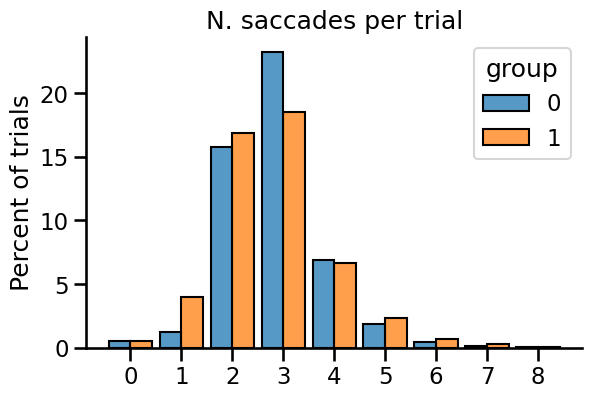

In [8]:
p = sns.histplot(data=df.reset_index(), hue = 'group', x='n_saccades', 
                 bins=np.arange(-.5, 9.5, 1), multiple="dodge", shrink=.85, stat='percent',
                legend=True)
p.set_ylabel('Percent of trials')
p.set_title('N. saccades per trial')
p.set_xlabel(None)
p.set_xticks(np.arange(0, 9))

p.set_aspect(1/4.)
sns.despine()


In [9]:
import pingouin as pg


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_77789/1451973798.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.reset_index().groupby(['subject']).mean().reset_index()


Text(0.5, 1.02, 'N. saccades per trial per subject \n p-val= 0.4912')

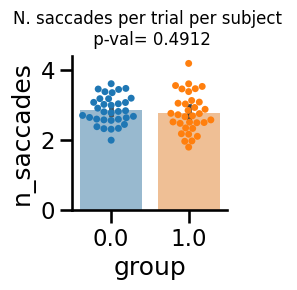

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [10]:
fig, ax = plt.subplots(figsize=(2,2))
y_var = 'n_saccades'
tmp = df.reset_index().groupby(['subject']).mean().reset_index()
sns.barplot(x='group', y=y_var,hue='group', data=tmp,
            ax=ax,legend=False,alpha=.5)
sns.swarmplot(x='group', hue='group', y=y_var, data=tmp,
                   legend=False, ax=ax, size=5)
an = pg.anova(data=tmp, dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],4)
sns.despine()
plt.title(f'N. saccades per trial per subject \n p-val= {p_val}', y=1.02, fontsize=12)


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_77789/689901554.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject']).mean()


Text(0.5, 1.3, 'Saccade left direction')

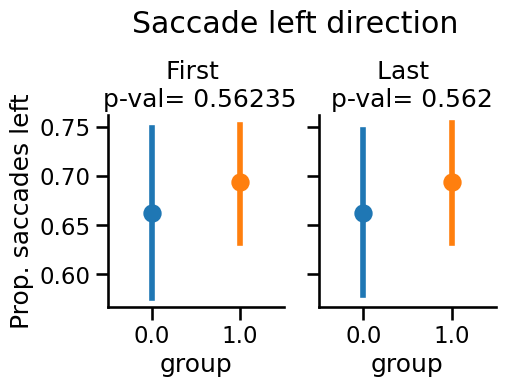

In [11]:
tmp = df.groupby(['subject']).mean()

fig, axs = plt.subplots(1, 2, figsize=(5,2.5), sharey=True)
sns.pointplot(data=tmp.reset_index(), x='group', y='first_saccade_left', hue='group', ax=axs[0],legend=False)
an = pg.anova(data=tmp, dv='first_saccade_left', between='group')
p_val = np.round(an['p-unc'][0],5)
axs[0].set_title(f'First \n p-val= {p_val}')
axs[0].set_ylabel('Prop. saccades left')
sns.pointplot(data=tmp.reset_index(), x='group', y='last_saccade_left', hue='group', ax=axs[1],legend=False)
an = pg.anova(data=tmp, dv='last_saccade_left', between='group')
p_val = np.round(an['p-unc'][0],3)
axs[1].set_title(f'Last \n p-val= {p_val}')
sns.despine()
fig.suptitle('Saccade left direction', y=1.3)

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_77789/2707927297.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject']).mean()


Text(0.5, 1.15, 'Saccade risky option')

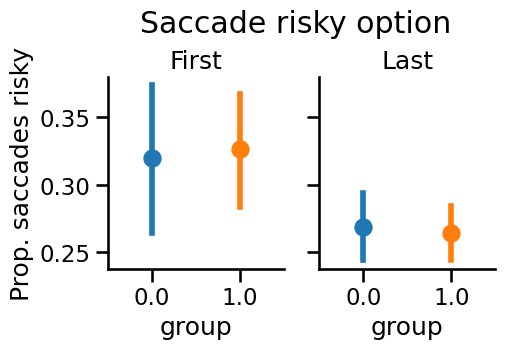

In [12]:
tmp = df.groupby(['subject']).mean()

fig, axs = plt.subplots(1, 2, figsize=(5,2.5), sharey=True)

sns.pointplot(data=tmp.reset_index(), x='group', y='last_saccade_risky', hue='group', ax=axs[1],legend=False)
axs[1].set_title('Last')
axs[0].set_ylabel('Prop. saccades risky')
sns.pointplot(data=tmp.reset_index(), x='group', y='first_saccade_risky', hue='group', ax=axs[0],legend=False)
axs[0].set_title('First')
sns.despine()
fig.suptitle('Saccade risky option', y=1.15)

## Interaction with choice

In [15]:
# last option looked at is chosen

df['last_saccade_chosen'] = (df['last_saccade'] == 'left_option') & (df['chose_left']) | \
                            (df['last_saccade'] == 'right_option') & (~df['chose_left'])

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_77789/3461337108.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject']).mean()
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.02, 'Last saccade chosen \n p-val= 0.7655')

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


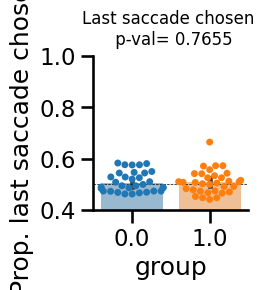

In [17]:
import pingouin as pg

tmp = df.groupby(['subject']).mean()
fig, ax = plt.subplots(figsize=(2,2))
y_var = 'last_saccade_chosen'
sns.barplot(x='group', y=y_var, hue='group', data=tmp.reset_index(),
            ax=ax,legend=False,alpha=.5)
sns.swarmplot(x='group', hue='group', y=y_var, data=tmp.reset_index(),
                   legend=False, ax=ax, size=5)
ax.set(ylim=(.4,1), ylabel='Prop. last saccade chosen')
ax.axhline(.5, ls='--', color='k', lw=.5)
an = pg.anova(data=tmp, dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],4)
sns.despine()
plt.title(f'Last saccade chosen \n p-val= {p_val}', y=1.02, fontsize=12)

--> kind of does not work?? plot  `Prop. fixation (risky, left, chosen) vs. Fixation number...` underneath, as Gilles did.. 
to see if this makes sense at all

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_77789/3682380805.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject']).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_77789/3682380805.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject','first_saccade_risky' ]).mean()
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_77789/3682380805.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or s

Text(0.5, 1.15, 'Chose Risky ~ saccade risky option')

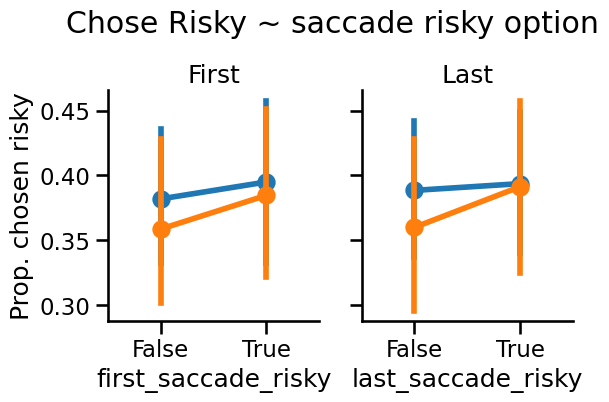

In [18]:
y_var = 'chose_risky'
tmp = df.groupby(['subject']).mean()

fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)

tmp = df.groupby(['subject','first_saccade_risky' ]).mean()
sns.pointplot(data=tmp.reset_index(), x='first_saccade_risky', y=y_var, hue='group', ax=axs[0],legend=False)
axs[0].set_title('First')
axs[0].set_ylabel('Prop. chosen risky')
tmp = df.groupby(['subject','last_saccade_risky' ]).mean()
sns.pointplot(data=tmp.reset_index(), x='last_saccade_risky', y=y_var, hue='group', ax=axs[1],legend=False)
axs[1].set_title('Last')
sns.despine()
fig.suptitle('Chose Risky ~ saccade risky option', y=1.15)

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_10239/4098893556.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject',x_var ]).mean()


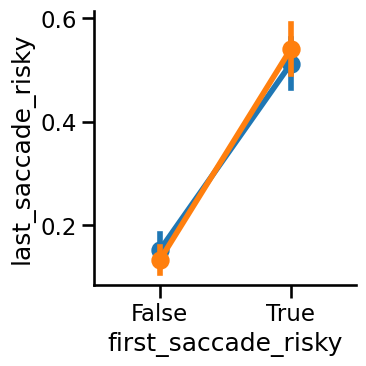

In [ ]:

x_var = 'first_saccade_risky'
y_var = 'last_saccade_risky'

tmp = df.groupby(['subject',x_var ]).mean()

sns.catplot(tmp.reset_index(), y=y_var, x=x_var, hue='group',kind='point',height=4, aspect=1, legend=False)

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_77789/2067711230.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject', col_var,x_var ]).mean()


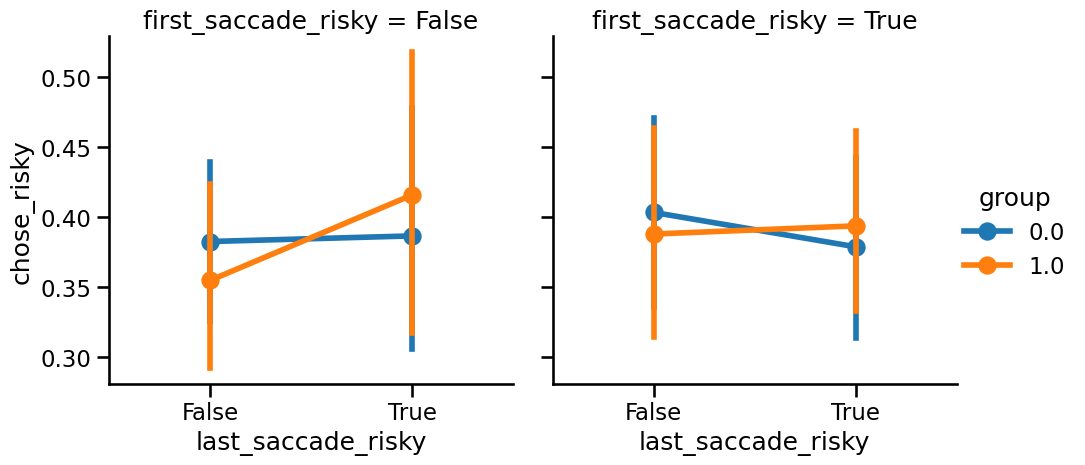

In [20]:
col_var = 'first_saccade_risky'#'log(risky/safe)' #'n_risky'
x_var = 'last_saccade_risky'
tmp = df.groupby(['subject', col_var,x_var ]).mean()

sns.catplot(tmp.reset_index(), y='chose_risky', x= x_var, col=col_var, hue='group',kind='point')

--> for dyscalculics first_saccade more important, for controls last saccade?

No, only when first saccade was risky, also last saccade increases/decreases chance of chosing risky.... 

In [21]:
df['risky_duration'] = df['left_duration'].where(df['risky_left'], df['right_duration'])
df['safe_duration'] = df['right_duration'].where(df['risky_left'], df['left_duration'])

df['duration_option_difference'] = df['risky_duration'] - df['safe_duration']
df['duration_side_difference'] = df['left_duration'] - df['right_duration']

#df['duration_option_difference_abs'] = df['duration_option_difference'].abs()
#df['duration_side_difference_abs'] = df['duration_side_difference'].abs() # --> these are the same per trial... but not necessacrily per subject!?
df['duration_difference_abs'] = df['duration_side_difference'].abs()  # == df['duration_option_difference'].abs()

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_77789/1567480532.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject']).mean()
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/Users/

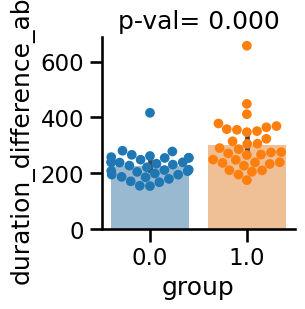

In [22]:
from pingouin import pairwise_tests

tmp = df.groupby(['subject']).mean()

fig, axs = plt.subplots(1, 1, figsize=(2.5,2.5))
i = 0
col ='duration_difference_abs'
sns.barplot(tmp.reset_index(), y=col, x='group', hue='group',  ax=axs,legend=False,alpha=0.5)
sns.swarmplot(tmp.reset_index(), y=col, x='group', hue='group',  ax=axs,legend=False,size=7)
stats = pairwise_tests(tmp.reset_index(), dv=col, between='group')
axs.set(title=f'p-val= {stats["p-unc"].values[0]:.3f}')
sns.despine()

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new ar

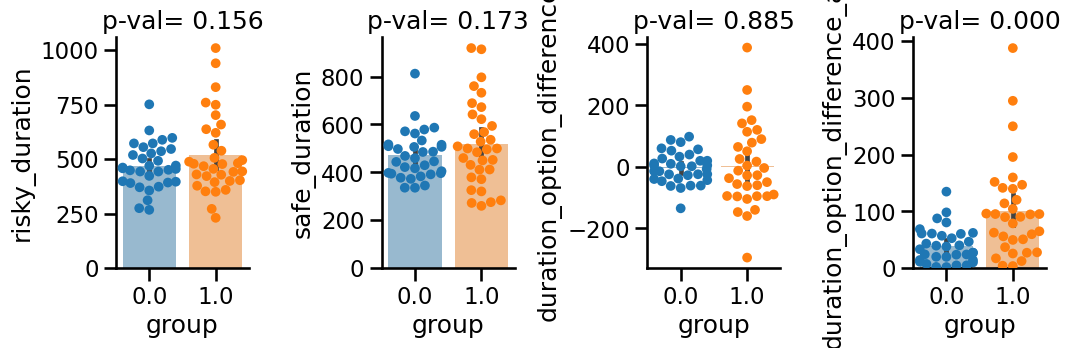

In [23]:
# difference fixations on risky vs safe?
from pingouin import pairwise_tests
tmp = df.groupby(['subject']).mean(numeric_only=True)
tmp['duration_option_difference_abs'] = tmp['duration_option_difference'].abs()

fig, axs = plt.subplots(1, 4, figsize=(12,3))

for i, col in enumerate(['risky_duration', 'safe_duration', 'duration_option_difference','duration_option_difference_abs']):
    sns.barplot(tmp.reset_index(), y=col, x='group', hue='group',  ax=axs[i],legend=False,alpha=0.5)
    sns.swarmplot(tmp.reset_index(), y=col, x='group', hue='group',  ax=axs[i],legend=False,size=7)
    stats = pairwise_tests(tmp.reset_index(), dv=col, between='group')
    axs[i].set(title=f'p-val= {stats["p-unc"].values[0]:.3f}')

sns.despine()
fig.subplots_adjust(wspace=1)


In [24]:
# non parametric test
from scipy.stats import mannwhitneyu

var = 'duration_option_difference_abs'
stats = mannwhitneyu(tmp[var].loc[tmp['group'] == 0], tmp[var].loc[tmp['group'] == 1])
stats

MannwhitneyuResult(statistic=252.0, pvalue=0.00018057780969861563)

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new ar

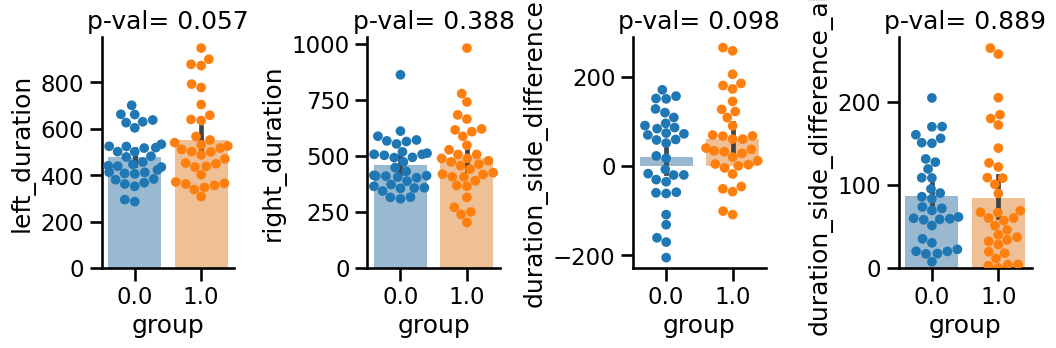

In [25]:
# difference fixations on risky vs safe?
from pingouin import pairwise_tests
tmp = df.groupby(['subject']).mean(numeric_only=True)
tmp['duration_side_difference_abs'] = tmp['duration_side_difference'].abs()

fig, axs = plt.subplots(1, 4, figsize=(12,3))

for i, col in enumerate(['left_duration', 'right_duration', 'duration_side_difference','duration_side_difference_abs']):
    sns.barplot(tmp.reset_index(), y=col, x='group', hue='group',  ax=axs[i],legend=False,alpha=0.5)
    sns.swarmplot(tmp.reset_index(), y=col, x='group', hue='group',  ax=axs[i],legend=False,size=7)
    stats = pairwise_tests(tmp.reset_index(), dv=col, between='group')
    axs[i].set(title=f'p-val= {stats["p-unc"].values[0]:.3f}')

sns.despine()
fig.subplots_adjust(wspace=1)


## Modelling the influences of eyepos on choice

### simple stat models

In [47]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

var_1 = 'first_saccade_risky'
var_2 = 'last_saccade_risky'

tmp = df.reset_index().groupby(['subject',var_1, var_2]).mean().reset_index()
#formula = f'chose_risky ~  C(group) + C({var_1}) + C({var_2}) + C(group):C({var_1}) + C(group):C({var_2})'
#formula = f'chose_risky ~ group*{var_1}*{var_2} + last_saccade_risky:C(subject)' # + C(group):C({var_1}) + C(group):C({var_2})'
formula = f'chose_risky ~ group*first_saccade_risky*last_saccade_risky + first_saccade_risky:C(subject) + last_saccade_risky:C(subject)'

model = ols(formula, data=tmp.reset_index()).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            chose_risky   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     4.917
Date:                Wed, 18 Jun 2025   Prob (F-statistic):           1.20e-11
Time:                        16:20:29   Log-Likelihood:                 404.56
No. Observations:                 264   AIC:                            -409.1
Df Residuals:                      64   BIC:                             306.1
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_10239/387054889.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.reset_index().groupby(['subject',var_1, var_2]).mean().reset_index()


In [44]:
stats_df = pd.DataFrame({
    'coef': model.params,
    'std_err': model.bse,
    't': model.tvalues,
    'p': model.pvalues
})
stats_df['p'] = stats_df['p'].apply(lambda x: f"{x:.3f}")

stats_df

,coef,std_err,t,p
Intercept,0.223649,0.092398,2.420495,0.018
first_saccade_risky[T.True],-0.165246,0.107753,-1.533553,0.130
last_saccade_risky[T.True],0.768088,0.107753,7.128192,0.000
first_saccade_risky[T.True]:last_saccade_risky[T.True],0.059551,0.036959,1.611274,0.112
first_saccade_risky[False]:C(subject)[T.2],-0.114686,0.090677,-1.264769,0.211
...,...,...,...,...
last_saccade_risky[T.True]:C(subject)[T.66],-0.643621,0.150129,-4.287126,0.000
group,0.129881,0.089757,1.447027,0.153
group:first_saccade_risky[T.True],0.204415,0.103113,1.982449,0.052
group:last_saccade_risky[T.True],-0.714906,0.107616,-6.643103,0.000


In [45]:
filtered_stats = stats_df[~stats_df.index.str.contains(r':C\(subject\)\[T\.', regex=True)]
filtered_stats

,coef,std_err,t,p
Intercept,0.223649,0.092398,2.420495,0.018
first_saccade_risky[T.True],-0.165246,0.107753,-1.533553,0.130
last_saccade_risky[T.True],0.768088,0.107753,7.128192,0.000
first_saccade_risky[T.True]:last_saccade_risky[T.True],0.059551,0.036959,1.611274,0.112
group,0.129881,0.089757,1.447027,0.153
group:first_saccade_risky[T.True],0.204415,0.103113,1.982449,0.052
group:last_saccade_risky[T.True],-0.714906,0.107616,-6.643103,0.000
group:first_saccade_risky[T.True]:last_saccade_risky[T.True],-0.110183,0.052268,-2.108037,0.039
